---
syncID: 
title: "Intro to working with AOP remote sensing and GBIF occurence data in Google Earth Engine Python (geemap)"
description: "Explore AOP reflectance along iwth "
dateCreated: 2023-04-23
authors: Kit Lewers
contributors: Bridget Hass
estimatedTime: 1 hour
packagesLibraries: earthengine-api, geemap, geopandas, pygbif, shapely
topics:
languagesTool: Python, Google Earth Engine
dataProducts: DP3.30006.001, DP3.30006.002
code1: https://github.com/NEONScience/NEON-Data-Skills/edit/main/tutorials/Other/GEE_Python/04_aop_gbif_gee_py/Intro_AOP_GBIF_GEE_Python.ipynb
tutorialSeries: 
urlTitle: aop-gbif-gee-py
---

## Exploring NEON AOP (Airborne Operations Platform) and BioRepository Data Together

In this tutorial, we will pull in NEON AOP hyperspectral data collected in 2016 and 2017 at the NEON <a href="https://www.neonscience.org/field-sites/grsm" target="_blank">GRSM (Great Smokey Mountains)</a> site. Between the 2016 and 2017 data collections, the <a href="https://www.neonscience.org/impact/observatory-blog/neons-great-smoky-mountains-data-will-capture-tennessee-fire-impacts-local" target="_blank">Chimney Tops Fire</a> occurred within the flight box, leaving a prominent burn scar. We will use the GEE (Google Earth Engine) Python API to explore the burn scar using the NBR (Normalized Burn Ratio) to set a threshold to identify burned and unburned areas. We will then us the PyGBIF API (Python Global Biodiversity Information Facility) to pull records from the NEON BioRepository to see if and/or how Carabid beetle traps in the domain were impacted by the fires.

<div id="ds-objectives" markdown="1">

### Objectives
After completing this tutorial, you will be able to use Python to:

* Read in multiple visits and visualize AOP reflectance datasets
* Calculate NBR (Normalized Burn Ratio) from reflectance data
* Read in GBIF Occurence Records using the pygbif package
* Visualize AOP Imagery and GBIF records together
* Conduct exploratory analysis to see if and how the fire impacted the beetle traps

### Requirements

To follow along with this code, you will need to:
1. Sign up for a non-commercial Google Earth Engine account here https://code.earthengine.google.com/register.
2. Install **Python 3.10+**
3. Install required Python packages
   
- `pip install earthengine-api --upgrade`
- `pip install geemap`
- `pip install pygbif`
- `pip install geopandas`
- `pip install shapely`

### Additional Resources
- <a href="https://www.neonscience.org/resources/learning-hub/tutorials/aop-gee-py-intro" target="_blank">Intro to AOP Datasets in Google Earth Engine (GEE) using Python</a>
- <a href="https://developers.google.com/earth-engine/tutorials/community/intro-to-python-api" target="_blank">Google Developers Intro to Python API</a>
- <a href="https://book.geemap.org/" target="_blank">`geemap` Text Book</a>
- <a href="https://www.youtube.com/@giswqs" target="_blank">`geemap` YouTube Channel</a>

</div>



## Part 1: Reading in and Visualizing AOP Imagery and GBIF Occurence Records

#### Step 1: Import required packages

In [1]:
from pygbif import occurrences as gbif_occ
import geopandas as gpd
import json
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from shapely import wkt

In [2]:
import ee
import geemap

To use the `ee` package, you will first need to Authenticate and Initialize

In [3]:
ee.Authenticate()

True

In [4]:
ee.Initialize()
#ee.Initialize(`gcp-project-name`)

#### Step 2: Pull NEON Imagery from GEE

In [5]:
# Define an area of interest, for the imagery, I will simply be using a centroid because I want all
# the imagery from GRSM domain. You can using a bounding box, shapefiles, etc. if you want a more granular
# control of the geographic area
site_center = ee.Geometry.Point([-83.5, 35.7])

# Load Hyperspectral AOP Image Collection
sdr_col = ee.ImageCollection('projects/neon-prod-earthengine/assets/HSI_REFL/001')

# Retrieve all available image IDs to make a list if you want to see everything, but also to cross 
# reference years you may want
image_ids = sdr_col.aggregate_array("system:index").getInfo()
print("Available AOP Image IDs:", image_ids)

# Define a function that allows you to look through multiple years and domains of image collections
def filter_aop_images(years, domains):
    """
    Filters the AOP image collection based on a list of years and domains.
    
    Parameters:
        years (list): List of years (e.g., ["2016", "2017"]).
        domains (list): List of 4-letter site codes (e.g., ["GRSM", "HARV"]).
    
    Returns:
        Dictionary with (year, domain) as key and list of matching image IDs.
    """
    filtered_results = {}

    for year in years:
        for domain in domains:
            matching_ids = [img_id for img_id in image_ids if year in img_id and domain in img_id]
            if matching_ids:
                filtered_results[(year, domain)] = matching_ids

    return filtered_results

# Define years and domains that you want to look at (NOTE: this code can be used from multiple years
# and domains)
years_input = ["2016", "2017"]  # Add multiple years here
domains_input = ["GRSM"]  # Add multiple domains here

# Get image filtered by year and domain
filtered_images = filter_aop_images(years_input, domains_input)

# NEON does not fly every single domain every year so there may be years where imagery is unavailable
# I like to have a conditional statement so I can easily check if there are no images available, but 
# also print a list in case only some years are available
if not filtered_images:
    print(f"No AOP images found for the selected years and domains.")
else:
    print(f"AOP images matching search criteria: {filtered_images}")


Available AOP Image IDs: ['2013_CPER_1', '2014_HARV_2', '2014_JERC_1', '2015_MLBS_1', '2015_TALL_1', '2016_CLBJ_1', '2016_GRSM_2', '2016_HARV_3', '2016_JERC_2', '2016_SERC_1', '2016_TALL_2', '2017_CLBJ_2', '2017_CPER_3', '2017_GRSM_3', '2017_HARV_4', '2017_JERC_3', '2017_MLBS_2', '2017_OAES_2', '2017_SERC_3', '2017_SRER_1', '2017_TALL_3', '2018_GUAN_1', '2018_HARV_5', '2018_JERC_4', '2018_MCRA_1', '2018_MLBS_3', '2018_OAES_3', '2018_SRER_2', '2018_TALL_4', '2019_CLBJ_4', '2019_HARV_6', '2019_HEAL_3', '2019_JERC_5', '2019_JORN_3', '2019_NIWO_3', '2019_OAES_4', '2019_SERC_4', '2019_SOAP_4', '2019_SRER_3', '2019_TALL_5', '2020_CPER_5', '2020_CPER_7', '2020_NIWO_4', '2020_RMNP_3', '2020_YELL_3', '2021_ABBY_4', '2021_BONA_4', '2021_CLBJ_5', '2021_CPER_8', '2021_HEAL_4', '2021_JERC_6', '2021_JORN_4', '2021_MCRA_2', '2021_OAES_5', '2021_OSBS_6', '2021_SERC_5', '2021_SJER_5', '2021_SOAP_5', '2021_SRER_4', '2021_TALL_6']
AOP images matching search criteria: {('2016', 'GRSM'): ['2016_GRSM_2'], (

#### Step 2: Calculate NBR (Normalized Burn Ratio) and visualize for 2016 and 2017 imagery

In [6]:
# NBR Visualization Parameters
nbr_vis_params = {
    'min': -1, 'max': 1,
    'palette': ['white', 'yellow', 'red', 'black']  # typical burn severity color ramp
}

# Function to Compute NBR
def addNBRBands(image):
    nbr = image.normalizedDifference(['B097', 'B220']).rename('NBR')
    return image.addBands(nbr).set({'Sensor': 'AOP'})

# Create a geemap Map instance for NBR visualization
NBR_Map = geemap.Map()
NBR_Map.centerObject(site_center, 11)

# Loop through filtered images and compute NBR
for (year, domain), image_ids in filtered_images.items():
    for image_id in image_ids:
        # Retrieve the image by its system:index
        aop_image = sdr_col.filter(ee.Filter.eq("system:index", image_id)).first()

        # Compute NBR
        if aop_image:
            aop_nbr = addNBRBands(aop_image).select('NBR')
            print(f"NBR computed for AOP image: {image_id}")

            # Add layer with proper naming
            NBR_Map.addLayer(aop_nbr, nbr_vis_params, f'AOP NBR ({image_id})')

# Save the final interactive HTML map for NBR
html_nbr_filename = f"AOP_NBR_{'_'.join(years_input)}_{'_'.join(domains_input)}.html"
NBR_Map.to_html(filename=html_nbr_filename)

print(f"NBR visualization saved: {html_nbr_filename}")

NBR computed for AOP image: 2016_GRSM_2
NBR computed for AOP image: 2017_GRSM_3
NBR visualization saved: AOP_NBR_2016_2017_GRSM.html


You can open up the html to interactively view the 2016 and 2017 NBR images. You should see something the following:

<table><tr>
<td> <img src="https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/main/graphics/aop-gee-python/aop_gbif/GRSM_2016_NBR.png" width="600"> </td>
<td> <img src="https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/main/graphics/aop-gee-python/aop_gbif/GRSM_2017_NBR.png" width="600"> </td>
</table>
<figcaption>Normalized Burn Ratio (NBR) at the NEON GRSM site before the Chimney Tops Fire (2016, left) and after the fire (2017, right).  
</figcaption>

#### Reading in GBIF Occurences Data

Next we'll read in the carabid beetle records from `pygbif occurences`, imported as `gbif_occ` and create a geodataframe from those data.

In [7]:
# GRSM centroid and bounding box parameters
latitude, longitude = 35.6118, -83.4895
bbox_size_deg = 0.09  # Approx. 10 km (~0.09 degrees)

# Create bounding box polygon
bounding_box_coords = [
    (longitude - bbox_size_deg, latitude - bbox_size_deg),  # Bottom-left
    (longitude + bbox_size_deg, latitude - bbox_size_deg),  # Bottom-right
    (longitude + bbox_size_deg, latitude + bbox_size_deg),  # Top-right
    (longitude - bbox_size_deg, latitude + bbox_size_deg),  # Top-left
    (longitude - bbox_size_deg, latitude - bbox_size_deg)   # Close polygon
]
bounding_polygon = Polygon(bounding_box_coords)
polygon_wkt = bounding_polygon.wkt

# Get carabid records
carabid_records = []
carabid_taxon_key = 3792  # <-- update with correct taxon key for Carabidae
for year in [2016, 2017]:
    occurrences = gbif_occ.search(
        taxonKey=carabid_taxon_key,
        geometry=polygon_wkt,
        year=year,
        hasCoordinate=True,
        limit=300
    )
    prefix = f"grsm.{year}".lower()
    for occ in occurrences.get("results", []):
        if "eventID" in occ and occ["eventID"].lower().startswith(prefix):
            try:
                lat = float(occ["decimalLatitude"])
                lon = float(occ["decimalLongitude"])
                carabid_records.append({
                    "species": occ.get("species", "Unknown"),
                    "latitude": lat,
                    "longitude": lon,
                    "year": year,
                    "eventID": occ.get("eventID")
                })
            except (KeyError, TypeError, ValueError):
                continue

# Convert carabid records to GeoDataFrame and export as GeoJSON and CSV
carabid_gdf = gpd.GeoDataFrame(
    carabid_records,
    geometry=gpd.points_from_xy(
        [r['longitude'] for r in carabid_records],
        [r['latitude'] for r in carabid_records]
    ),
    crs="EPSG:4326"
)

# Write the geodataframe to a geojson and csv file
carabid_gdf.to_file("gbif_carabids_grsm_2016_2017.geojson", driver="GeoJSON")
carabid_gdf.drop(columns='geometry').to_csv("gbif_carabids_grsm_2016_2017.csv", index=False)

INFO:Created 416 records


#### Visualize AOP Imagery and GBIF records together

In [8]:
# Load GBIF records from the GeoJSON file
gbif_geojson = "gbif_carabids_grsm_2016_2017.geojson"
carabid_gdf = gpd.read_file(gbif_geojson)

# Separate the GBIF records by year
carabid_2016 = carabid_gdf[carabid_gdf["year"] == 2016]
carabid_2017 = carabid_gdf[carabid_gdf["year"] == 2017]

# Add the GBIF points to the map as separate layers
NBR_Map.add_gdf(carabid_2016, layer_name="GBIF NEON Carabidae Trap Records 2016")
NBR_Map.add_gdf(carabid_2017, layer_name="GBIF NEON Carabidae Trap Records 2017")

# (Optional) Save the interactive NBR_map to an HTML file
output_html = "GRSM_GBIF_NBR_Map.html"
NBR_Map.to_html(filename=output_html)
print(f"Combined map saved as: {output_html}")

Combined map saved as: GRSM_GBIF_NBR_Map.html


Now if you open this new html, you should be able to see the Carabidae Trap Records:

<figure>
	<a href="https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/main/graphics/aop-gee-python/aop_gbif/GRSM_NBR_Carabidae_Trap_Records.png">
	<img src="https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/main/graphics/aop-gee-python/aop_gbif/GRSM_NBR_Carabidae_Trap_Records.png" alt="GRSM Trap Records" width="800">
    <figcaption>Great Smokey Mountain NBR overlaid with GBIF Carabidae Trap Records</figcaption></a>
</figure>

## Part 1: Additional Analysis

In this next step, we'll see if we can gain any insights as to if and how the fire impacted the GBIF records.

This next chunk of code vectorizes the burn scar mask, which is then used ...

In [9]:
# --- STEP 1: Select pre-fire and post-fire images ---
# Assuming filtered_images is a dictionary with keys like ('2016', 'GRSM') and ('2017', 'GRSM')
# Here we simply choose the first image ID for each year.
pre_fire_img_id = filtered_images.get(('2016', 'GRSM'))[0]
post_fire_img_id = filtered_images.get(('2017', 'GRSM'))[0]

# Retrieve the images from the collection
pre_fire_image = sdr_col.filter(ee.Filter.eq("system:index", pre_fire_img_id)).first()
post_fire_image = sdr_col.filter(ee.Filter.eq("system:index", post_fire_img_id)).first()

# --- STEP 2: Compute NBR for each image using your function ---
pre_fire_nbr = addNBRBands(pre_fire_image).select('NBR')
post_fire_nbr = addNBRBands(post_fire_image).select('NBR')

# --- STEP 3: Calculate dNBR (difference NBR) ---
dnbr = pre_fire_nbr.subtract(post_fire_nbr).rename('dNBR')

# --- STEP 4: Apply a threshold to classify burned areas ---
# Example: mark pixels as burned if dNBR > 0.27 (indicative of moderate to high burn severity)
burn_threshold = 0.27  # This value may be adjusted based on local calibration or sensor characteristics.
burned_area_mask = dnbr.gt(burn_threshold)

# Optional: visualize burned vs unburned areas using a simple palette.
dnbr_viz_params = {
    'min': 0,
    'max': 1,
    'palette': ['white', 'orange', 'red']
}

# --- STEP 5: Vectorize the Burn Scar Mask ---
# Define a region of interest (ROI) for vectorization.
# You might base this on an extent around your site_center; here we buffer the center by 5000m.
roi = site_center.buffer(5000)

# Convert the burned area mask into vectors (polygons)
burn_vectors = burned_area_mask.selfMask().reduceToVectors(
    geometry=roi,
    crs=post_fire_image.projection(), 
    scale=10,  # Adjust scale (pixel size) as appropriate for the data.
    geometryType='polygon',
    labelProperty='burned',
    reducer=ee.Reducer.countEvery()
)

# --- STEP 6: Visualize the dNBR, burned area, and vectorized burn scar on the map ---
# Create a geemap Map instance (if not already created)
NBR_Map = geemap.Map()
NBR_Map.centerObject(site_center, 11)

# Add dNBR layer
NBR_Map.addLayer(dnbr, dnbr_viz_params, 'dNBR (Pre-fire minus Post-fire)')

# Add burned area mask layer
NBR_Map.addLayer(burned_area_mask.selfMask(), {'palette': 'red'}, 'Burned Area Mask')

# Add burn scar vectors layer
NBR_Map.addLayer(burn_vectors, {}, 'Burn Scar Polygons')

# Optionally, save the interactive map
output_html = "GRSM_Burn_Scar_Map.html"
NBR_Map.to_html(filename=output_html)
print(f"Burn scar map saved as: {output_html}")

# --- Optional: Export the burn scar vectors as a shapefile ---
# If you wish to export the vector data from Earth Engine, use Export.table.toDrive
# Uncomment the code below to do this

# export_task = ee.batch.Export.table.toDrive(
#     collection=burn_vectors,
#     description='BurnScar_Shapefile_Export',
#     folder='EarthEngineExports',
#     fileFormat='SHP'
# )
# export_task.start()
# print("Export of burn scar shapefile initiated.")

Burn scar map saved as: GRSM_Burn_Scar_Map.html


If you open this next html, you can see the vectorized burn scar.

<figure>
	<a href="https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/main/graphics/aop-gee-python/aop_gbif/GRSM_Burn_Scar_Map.png">
	<img src="https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/main/graphics/aop-gee-python/aop_gbif/GRSM_Burn_Scar_Map.png" alt="GRSM Burn Scar" width="800">
    <figcaption>Great Smokey Mountains Chimney Tops Fire Burn Scar</figcaption></a>
</figure>

#### Compare overall trap collections abundance from 2016 to 2017

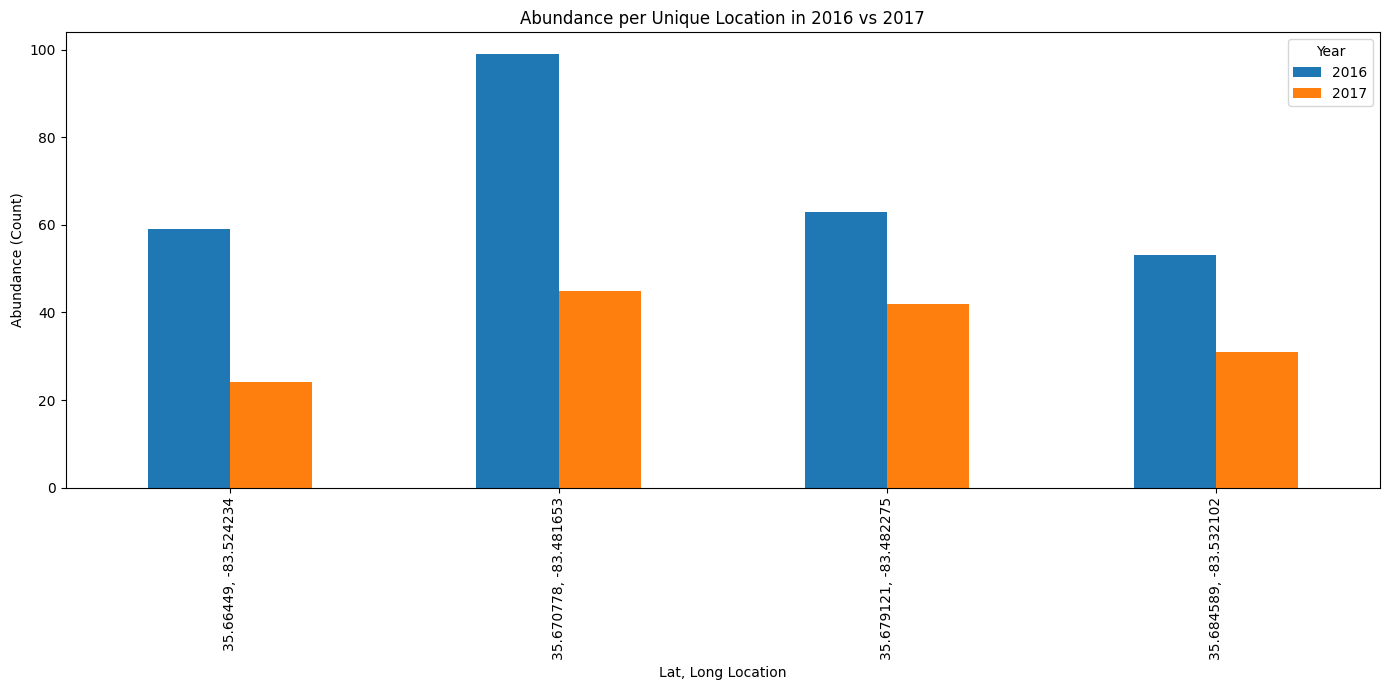

In [10]:
# Load the GBIF records from your GeoJSON file
gdf = gpd.read_file("gbif_carabids_grsm_2016_2017.geojson")

# Create a new column that identifies each unique location by combining latitude and longitude as a string.
# Adjust formatting as needed.
gdf['location'] = gdf['latitude'].astype(str) + ", " + gdf['longitude'].astype(str)

# Group by year and location, counting the number of occurrences (abundance) per location for each year.
abundance_by_loc = gdf.groupby(['year', 'location']).size().reset_index(name='count')

# Pivot the grouped DataFrame so that each unique location is a row and the columns are the counts for each year.
pivot_abundance = abundance_by_loc.pivot(index='location', columns='year', values='count').fillna(0)

# For clarity, sort the locations (this step is optional and dependent on your preference)
pivot_abundance = pivot_abundance.sort_index()

# Plot a grouped bar chart (histogram style) with unique locations on the x-axis and counts as bar heights.
ax = pivot_abundance.plot(kind='bar', figsize=(14, 7))

ax.set_xlabel("Lat, Long Location")
ax.set_ylabel("Abundance (Count)")
ax.set_title("Abundance per Unique Location in 2016 vs 2017")
ax.legend(title="Year")
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability

plt.tight_layout()
plt.show()

We can see that the abundances in 2017 are lower than 2016 at all four plots.

#### Compare species from year to year

                    species   latitude  longitude  year       eventID  \
0   Cyclotrachelus freitagi  35.664490 -83.524234  2016  GRSM.2016.18   
1     Pterostichus acutipes  35.679121 -83.482275  2016  GRSM.2016.18   
2  Gastrellarius blanchardi  35.664490 -83.524234  2016  GRSM.2016.18   
3             Tachys laevus  35.664490 -83.524234  2016  GRSM.2016.18   
4  Sphaeroderus bicarinatus  35.670778 -83.481653  2016  GRSM.2016.18   

                     geometry  
0  POINT (-83.52423 35.66449)  
1  POINT (-83.48228 35.67912)  
2  POINT (-83.52423 35.66449)  
3  POINT (-83.52423 35.66449)  
4  POINT (-83.48165 35.67078)  


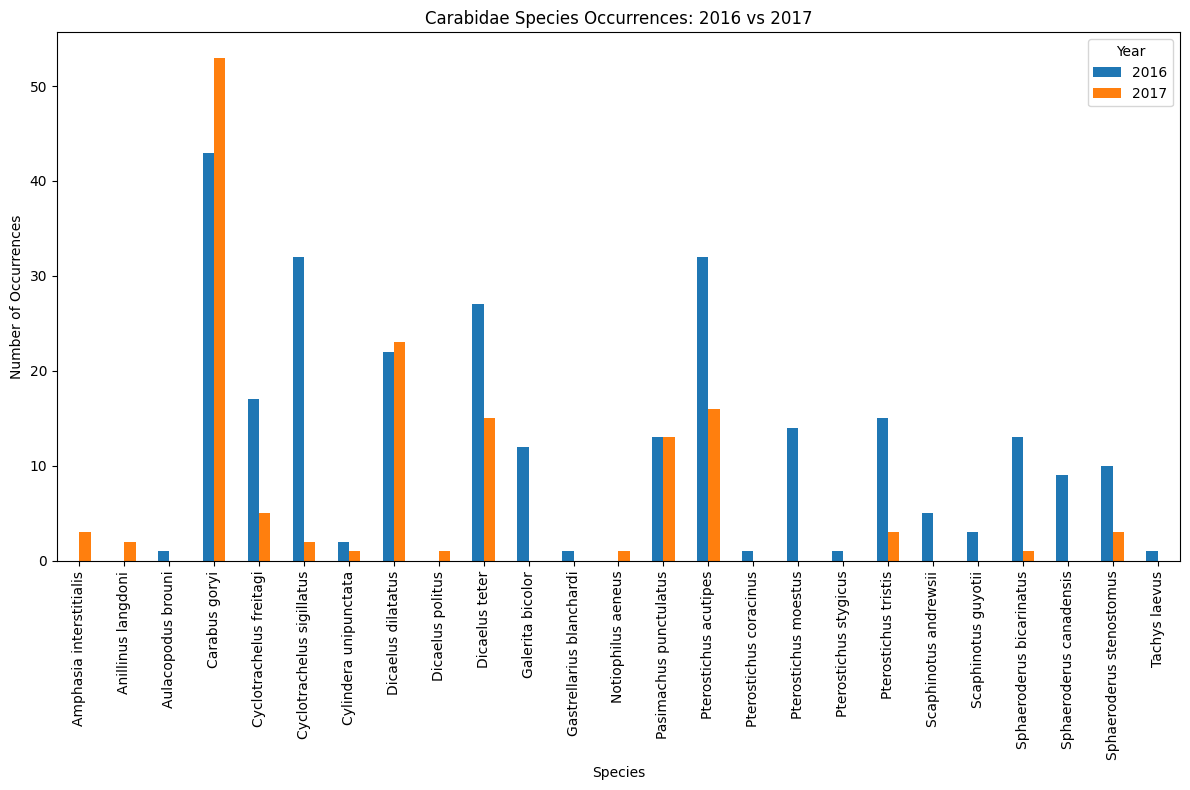

In [12]:
# Load the GBIF records from your GeoJSON file
gbif_geojson = "gbif_carabids_grsm_2016_2017.geojson"
gdf = gpd.read_file(gbif_geojson)

# Preview the data to ensure species and year fields are present
print(gdf.head())

# Group the data by species and year, and count the number of occurrences per group
# This creates a DataFrame with species as index and each year as a column.
species_counts = gdf.groupby(["species", "year"]).size().unstack(fill_value=0)

# Display the DataFrame to verify the counts (optional)
# print(species_counts)

# Plotting the counts in a grouped bar chart
ax = species_counts.plot(kind='bar', figsize=(12, 8))

# Add labels and title
ax.set_xlabel("Species")
ax.set_ylabel("Number of Occurrences")
ax.set_title("Carabidae Species Occurrences: 2016 vs 2017")
ax.legend(title="Year")

plt.tight_layout()
plt.show();

#### NBR values as a proxy for burn severity compared to trap areas

In [13]:
# Specify the local path to your GeoJSON file.
geojson_path = './gbif_carabids_grsm_2016_2017.geojson'

# Open and load the GeoJSON as a Python dictionary.
with open(geojson_path, 'r') as f:
    geojson_data = json.load(f)

# Extract unique coordinate pairs from the features.
# We assume each feature is a Point geometry.
unique_coords = {}
for feature in geojson_data['features']:
    # Get geometry details.
    geom = feature.get('geometry', {})
    if geom.get('type') == 'Point':
        # Coordinates are typically stored as [longitude, latitude].
        coord = tuple(geom.get('coordinates'))
        # Use the coordinates as a key to deduplicate.
        if coord not in unique_coords:
            unique_coords[coord] = coord

# Create a new GeoJSON with only the unique points.
unique_features = []
for coord in unique_coords.keys():
    new_feature = {
        "type": "Feature",
        "geometry": {
            "type": "Point",
            "coordinates": list(coord)
        },
        "properties": {}  # Only lat/long are kept.
    }
    unique_features.append(new_feature)

unique_geojson = {
    "type": "FeatureCollection",
    "features": unique_features
}

print("Number of unique trap points:", len(unique_features))

# Create an Earth Engine FeatureCollection from the unique GeoJSON.
traps = ee.FeatureCollection(unique_geojson)

# (Optional) Visualize the unique trap points using geemap.
Map = geemap.Map(center=[35.7, -83.5], zoom=11)
Map.addLayer(traps, {}, 'Unique Trap Coordinates')
Map

Number of unique trap points: 4


Map(center=[35.7, -83.5], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…

In [14]:
burn_mask = burned_area_mask.unmask(0).toFloat().rename('burn_mask')

traps_buffered = traps.map(lambda feature: feature.buffer(300))

# Step 4: Define a function to compute the percentage of burned pixels within each buffer.
def calculate_burn_percentage(feature):
    stats = burn_mask.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=feature.geometry(),
        scale=10,          # Adjust scale to match your sensor's resolution (e.g., 10 m)
        maxPixels=1e6
    )
    # The mean value corresponds to the fraction of burned pixels (0–1).
    burn_fraction = ee.Number(stats.get('burn_mask'))
    burn_percentage = burn_fraction.multiply(100)
    return feature.set({'burn_pct': burn_percentage})

# Apply the function to each buffered trap.
traps_with_burn = traps_buffered.map(calculate_burn_percentage)

# Optionally, print a sample of the computed burn percentages.
# print('Burn percentages for trap buffers:', traps_with_burn.limit(10).getInfo())

# (Optional) Visualize the trap areas with burn percentage values on your existing map.
NBR_Map.addLayer(traps_with_burn, {}, 'Trap Areas with Burn %')

# Convert the Earth Engine FeatureCollection (with burn percentages) to a GeoDataFrame
gdf_traps = geemap.ee_to_gdf(traps_with_burn)
print("Converted GeoDataFrame:")
print(gdf_traps.head())

# Option 1: Export as CSV using pandas.
# For CSV export, the geometry column may be better exported as WKT.
gdf_traps_csv = gdf_traps.copy()
gdf_traps_csv['geometry'] = gdf_traps_csv['geometry'].apply(lambda geom: geom.wkt if geom is not None else None)
csv_filename = "Trap_Burn_Percentages.csv"
gdf_traps_csv.to_csv(csv_filename, index=False)
print(f"Data exported as CSV: {csv_filename}")

# Option 2: Export as GeoJSON using GeoPandas.
# Here, we'll export the GeoDataFrame directly as a GeoJSON file.
geojson_filename = "Trap_Burn_Percentages.geojson"
# (Make sure the geometry column contains proper shapely geometries; if you already converted to WKT above, use the original gdf_traps.)
gdf_traps.to_file(geojson_filename, driver="GeoJSON")
print(f"Data exported as GeoJSON: {geojson_filename}")

INFO:Created 4 records


Converted GeoDataFrame:
                                            geometry   burn_pct
0  POLYGON ((-83.52753 35.66415, -83.52728 35.663...   5.093100
1  POLYGON ((-83.48557 35.67878, -83.48532 35.678...  23.721914
2  POLYGON ((-83.48495 35.67043, -83.4847 35.6697...   9.383024
3  POLYGON ((-83.5354 35.68425, -83.53515 35.6835...  13.115131
Data exported as CSV: Trap_Burn_Percentages.csv
Data exported as GeoJSON: Trap_Burn_Percentages.geojson


Occurrence data (pivot table):
year               location  2016  2017
0      35.66449, -83.524234    59    24
1     35.670778, -83.481653    99    45
2     35.679121, -83.482275    63    42
3     35.684589, -83.532102    53    31
Burn percentage data:
                location   burn_pct
0   35.66449, -83.524234   5.093100
1  35.679121, -83.482275  23.721914
2  35.670778, -83.481653   9.383024
3  35.684589, -83.532102  13.115131
Merged data:
                location  2016  2017   burn_pct
0   35.66449, -83.524234    59    24   5.093100
1  35.670778, -83.481653    99    45   9.383024
2  35.679121, -83.482275    63    42  23.721914
3  35.684589, -83.532102    53    31  13.115131


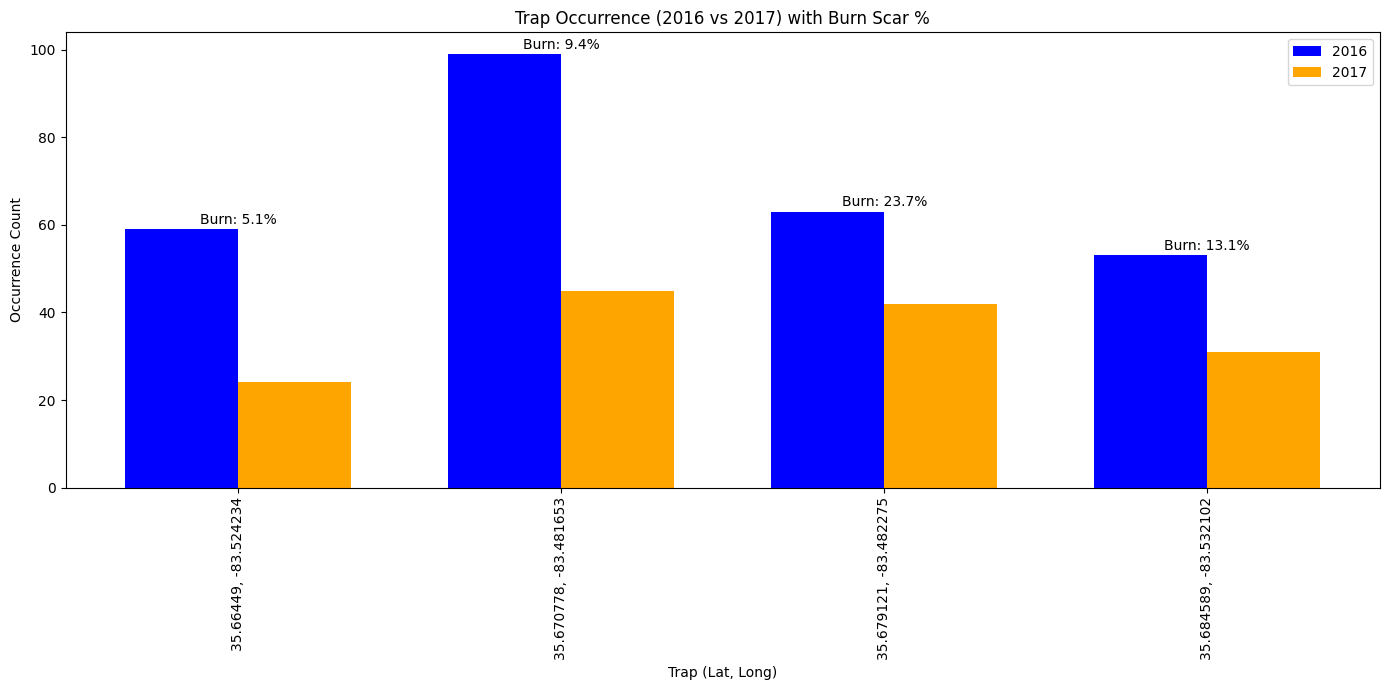

In [15]:
# ================================
# Step 1: Process occurrence data
# ================================

# Load the GBIF records from your GeoJSON file
occurrences_gdf = gpd.read_file("gbif_carabids_grsm_2016_2017.geojson")

# Create a new column that identifies each unique trap location.
# (We round the coordinates to 6 decimals to avoid slight floating-point mismatches.)
occurrences_gdf['location'] = occurrences_gdf['latitude'].round(6).astype(str) + ", " + occurrences_gdf['longitude'].round(6).astype(str)

# Group by year and location to count the number of occurrences per trap for each year.
occurrence_counts = occurrences_gdf.groupby(['year', 'location']).size().reset_index(name='count')

# Pivot the table so that each row is a unique trap (location) with columns for 2016 and 2017.
pivot_abundance = occurrence_counts.pivot(index='location', columns='year', values='count').fillna(0)
pivot_abundance = pivot_abundance.sort_index().reset_index()

print("Occurrence data (pivot table):")
print(pivot_abundance)


# ============================================
# Step 2: Load and process burn percentage data
# ============================================

# Load your exported CSV from Earth Engine.
# This file is assumed to be generated from your export task ("Trap_Burn_Percentage_Export.csv").
df_burn = pd.read_csv("Trap_Burn_Percentages.csv")

# Convert the geometry column (assumed to be in WKT format) into shapely geometry objects.
# The CSV export from EE typically includes a column "geometry" with WKT strings.
df_burn['geometry'] = df_burn['geometry'].apply(wkt.loads)

# Create a GeoDataFrame from the burn data.
gdf_burn = gpd.GeoDataFrame(df_burn, geometry='geometry', crs="EPSG:4326")

# Compute the centroid for each (buffer) polygon.
gdf_burn['centroid'] = gdf_burn.geometry.centroid

# Extract longitude and latitude from the centroids and round for consistent merging.
gdf_burn['lon'] = gdf_burn.centroid.x.round(6)
gdf_burn['lat'] = gdf_burn.centroid.y.round(6)

# Create a location string to match the occurrence data formatting.
gdf_burn['location'] = gdf_burn['lat'].astype(str) + ", " + gdf_burn['lon'].astype(str)

# Keep only the necessary columns (location and burn percentage)
burn_data = gdf_burn[['location', 'burn_pct']]

print("Burn percentage data:")
print(burn_data)


# ===============================================
# Step 3: Merge occurrence and burn percentage data
# ===============================================

# Merge the pivot abundance table with the burn data on the "location" column.
merged_df = pd.merge(pivot_abundance, burn_data, on='location', how='left')

print("Merged data:")
print(merged_df)


# ===================================================
# Step 4: Create the visualization (grouped bar chart)
# ===================================================

fig, ax = plt.subplots(figsize=(14, 7))

# Use the index (0, 1, 2, ...) for unique traps.
x_positions = range(len(merged_df))
bar_width = 0.35

# Plot bars for each year. We assume the pivot table columns are either integer years or strings.
# If needed, adjust the column names accordingly.
year2016 = merged_df[2016] if 2016 in merged_df.columns else merged_df['2016']
year2017 = merged_df[2017] if 2017 in merged_df.columns else merged_df['2017']

bars1 = ax.bar([i - bar_width/2 for i in x_positions], year2016, bar_width, label='2016', color='blue')
bars2 = ax.bar([i + bar_width/2 for i in x_positions], year2017, bar_width, label='2017', color='orange')

# Annotate each group with the burn percentage.
for i, row in merged_df.iterrows():
    # Get the maximum occurrence count between the two years for placement of text.
    max_count = max(row[2016] if 2016 in merged_df.columns else row['2016'], 
                    row[2017] if 2017 in merged_df.columns else row['2017'])
    ax.text(i, max_count + 0.5, f"Burn: {row['burn_pct']:.1f}%", ha='center', va='bottom', fontsize=10)

# Set the x-axis tick labels to be the location strings (which are "lat, long").
ax.set_xticks(x_positions)
ax.set_xticklabels(merged_df['location'], rotation=90)
ax.set_xlabel("Trap (Lat, Long)")
ax.set_ylabel("Occurrence Count")
ax.set_title("Trap Occurrence (2016 vs 2017) with Burn Scar %")
ax.legend()

plt.tight_layout()
plt.show()
